In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, UpSampling2D, Concatenate, MaxPooling2D
from tensorflow.keras import Model
from keras.callbacks import TensorBoard
from sklearn.utils import class_weight

## Load, weight, onehot data

In [2]:
dataset = np.load('../PdSeM_train_test.npz')
images = dataset['X_train'].reshape((-1, 256, 256, 1))
labels = dataset['y_train'].reshape((-1, 256, 256, 1))
images_test = dataset['X_test'].reshape((-1, 256, 256, 1))
labels_test = dataset['y_test'].reshape((-1, 256, 256, 1))

# Convert labels to one-hot encoding
labels_onehot = to_categorical(labels, num_classes=4)
labels_test_onehot = to_categorical(labels_test, num_classes=4)

In [3]:
np.shape(labels)

(8325, 256, 256, 1)

In [4]:
np.shape(labels_onehot)

(8325, 256, 256, 4)

In [6]:
# Calculate class weights
classes, class_freq = np.unique(labels, return_counts=True)
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = classes, y = labels.flatten())
class_weights = dict(enumerate(class_weights))
sample_weights = np.zeros_like(labels)
for i in range(len(class_weights)):
    sample_weights[labels == i] = class_weights[i]


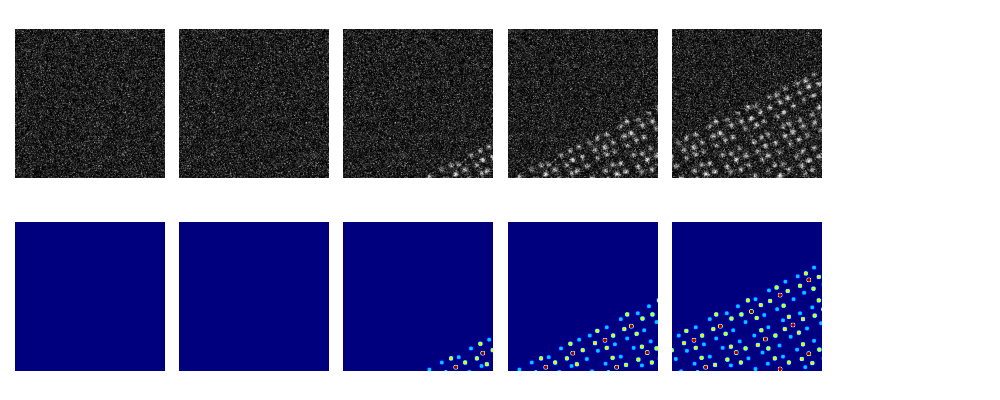

In [7]:
# plot the dataset
n = 5 # number of images to plot

n = n + 1
fig = plt.figure(figsize=(10, 4))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1,:,:], cmap='gray')
    #ax.set_title('Augmented image ' + str(i))
    ax.grid(alpha = 0.5)
    ax.set_axis_off()
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(labels[i-1], interpolation='Gaussian', cmap='jet')
    #ax.set_title('Ground truth ' + str(i))
    ax.grid(alpha=0.75)
    ax.set_axis_off()

fig.tight_layout()

## Build a new model:

In [8]:
def ConvBlock(x, filters):
    x = Conv2D(filters, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    return x

def UpsampleBlock(x, skip, filters):
    x = UpSampling2D(size=(2,2))(x)
    x = Concatenate()([x, skip])
    x = ConvBlock(x, filters)
    return x

def UNet(input_shape, actv = 'ReLU', n_classes = 4):
    inputs = Input(shape=input_shape)
    
    c1 = ConvBlock(inputs, filters=16)
    c2 = ConvBlock(c1, filters=32)
    c2_pool = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = ConvBlock(c2_pool, filters=64)
    c3_pool = MaxPooling2D(pool_size=(2, 2))(c3)
    
    bn = ConvBlock(c3_pool, filters=128)
    bn_up = UpsampleBlock(bn, c3, filters=64)
    
    c4 = ConvBlock(bn_up, filters=64)
    c4_up = UpsampleBlock(c4, c2, filters=32)
    
    c5 = ConvBlock(c4_up, filters=32)
    outputs = Conv2D(n_classes, kernel_size=(1,1), activation=actv)(c5)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

import tensorflow as tf
from keras.losses import Loss

class DiceLoss(Loss):
    def __init__(self, smooth=1e-5, **kwargs):
        super(DiceLoss, self).__init__(**kwargs)
        self.smooth = smooth

    def call(self, y_true, y_pred):
        intersection = tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        dice_score = (2.0 * intersection + self.smooth) / (denominator + self.smooth)
        dice_loss = 1.0 - dice_score
        return dice_loss

## Train the model:

In [13]:
# Compile the model
model = UNet(input_shape=(256,256,1), n_classes=4, actv='ReLU')
model.compile(optimizer='adam', loss=DiceLoss(smooth=10), metrics=['accuracy'])
model.fit(images, labels_onehot, batch_size=32, epochs=10, validation_data=(images_test, labels_test_onehot), shuffle = True, sample_weight = sample_weights)

Epoch 1/10


2023-08-15 10:21:07.180208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


261/261 [==============================] - ETA: 0s - loss: 0.7734 - accuracy: 0.9134

2023-08-15 10:26:49.088533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


261/261 [==============================] - 373s 1s/step - loss: 0.7734 - accuracy: 0.9134 - val_loss: -0.2521 - val_accuracy: 0.7930
Epoch 2/10
261/261 [==============================] - 456s 2s/step - loss: 0.5662 - accuracy: 0.9831 - val_loss: 1.0000 - val_accuracy: 0.8841
Epoch 3/10
261/261 [==============================] - 372s 1s/step - loss: 0.5448 - accuracy: 0.9979 - val_loss: 1.0000 - val_accuracy: 0.8841
Epoch 4/10
261/261 [==============================] - 370s 1s/step - loss: 0.4292 - accuracy: 0.9896 - val_loss: 1.0000 - val_accuracy: 0.8841
Epoch 5/10
261/261 [==============================] - 370s 1s/step - loss: 0.2793 - accuracy: 0.9981 - val_loss: 0.9301 - val_accuracy: 0.8841
Epoch 6/10
261/261 [==============================] - 1593s 6s/step - loss: 0.3015 - accuracy: 0.9981 - val_loss: 0.9937 - val_accuracy: 0.8841
Epoch 7/10
261/261 [==============================] - 376s 1s/step - loss: 0.2928 - accuracy: 0.9980 - val_loss: 0.9596 - val_accuracy: 0.8841
Epoch 8/

2023-08-15 11:44:54.423900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 30s 317ms/step


/var/folders/1h/36qxtl8567zdjv8nzdn4fzrr0000gn/T/ipykernel_15508/3616552050.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex = True, sharey = True)


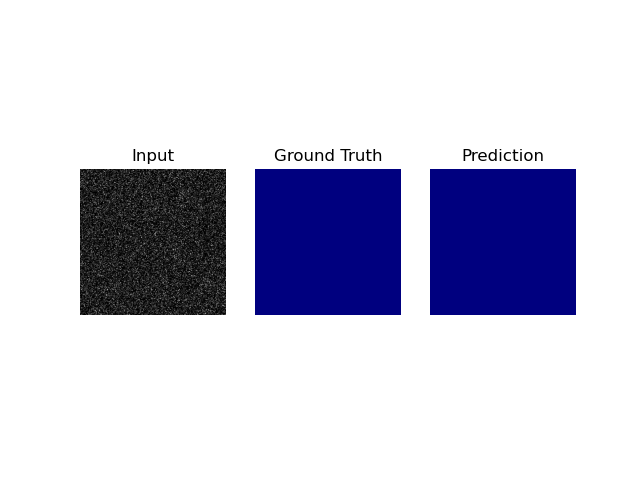

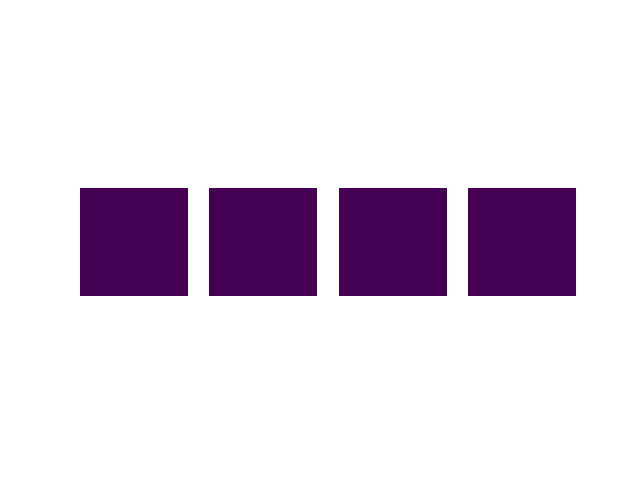

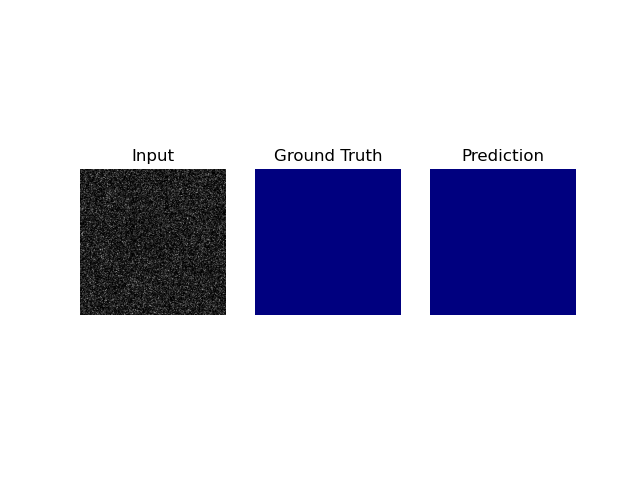

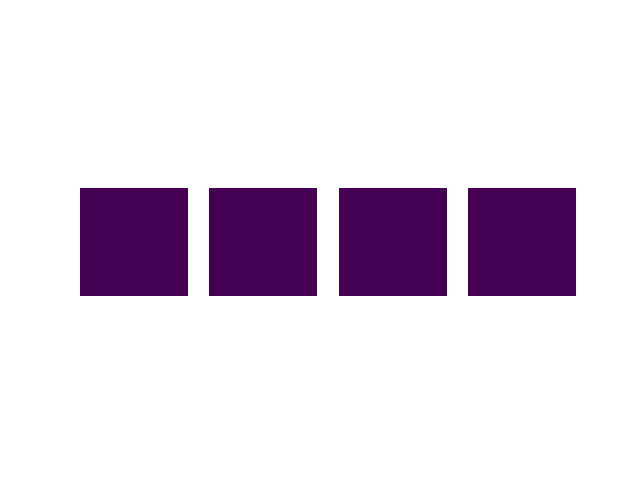

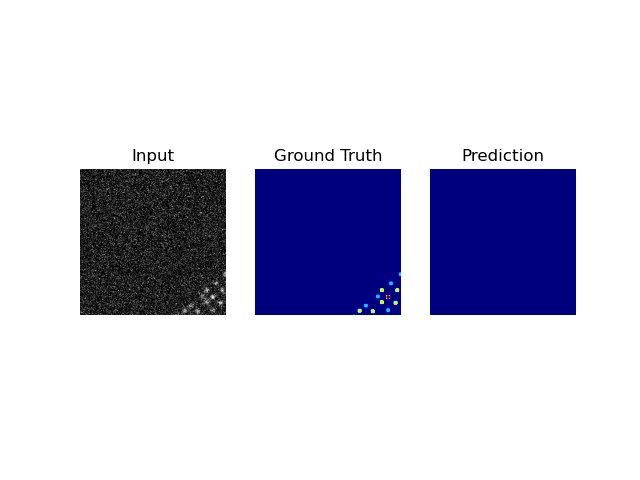

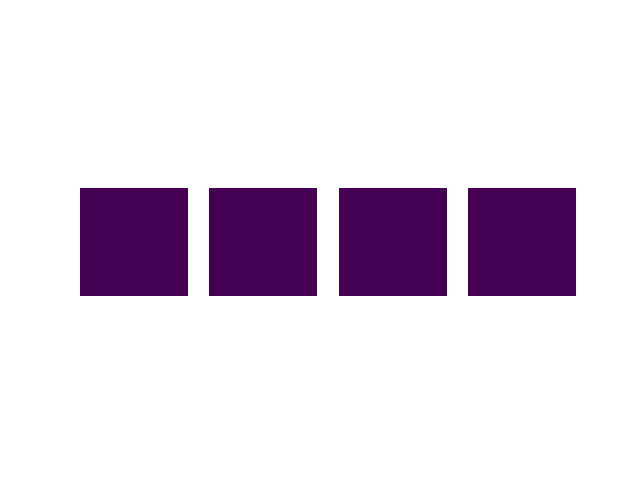

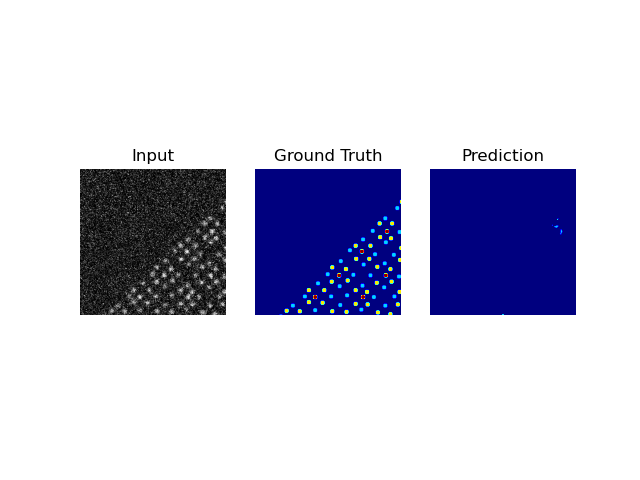

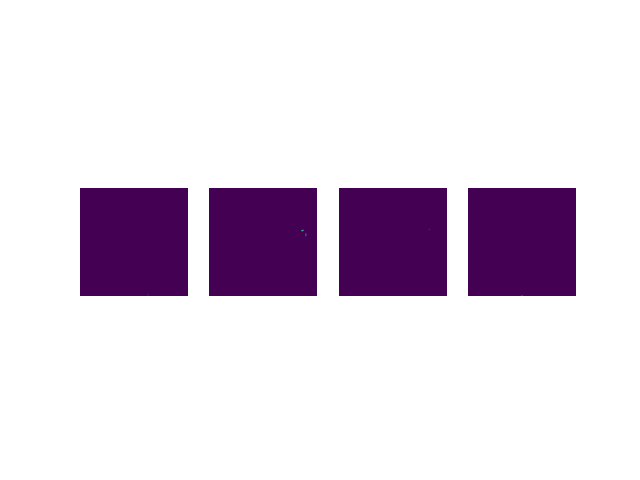

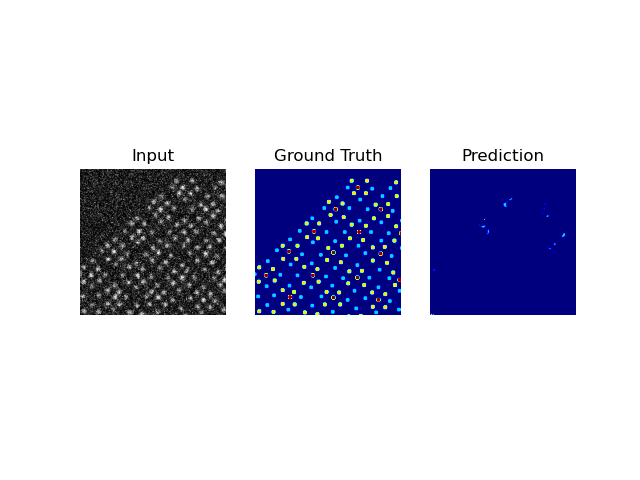

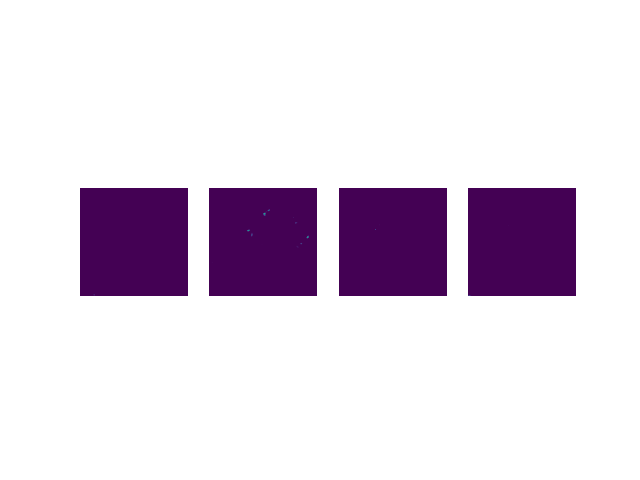

In [14]:
# Predict on new data
y_pred_onehot = model.predict(images_test)
# Convert one-hot encoded predictions back to label images
labels_pred = np.argmax(y_pred_onehot, axis=-1)

# plot predictions
for n in range(5):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex = True, sharey = True)
    ax1.set_title('Input')
    ax1.imshow(images_test[n], cmap = 'gray')
    ax2.set_title('Ground Truth')
    ax2.imshow(labels_test[n], cmap = 'jet')
    ax3.set_title('Prediction')
    ax3.imshow(labels_pred[n], cmap = 'jet')
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()


    fig, axs = plt.subplots(1,4)
    for i,ax in enumerate(np.ravel(axs)):
        ax.imshow(y_pred_onehot[n,:,:,i])
        ax.set_axis_off()

In [11]:
# Predict on new data
y_pred_onehot = model.predict(images_test)
# Convert one-hot encoded predictions back to label images
labels_pred = np.argmax(y_pred_onehot, axis=-1)

92/92 [==============================] - 17s 183ms/step


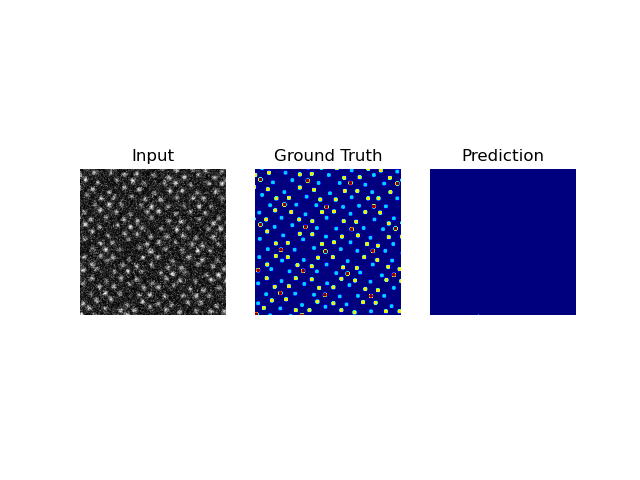

In [12]:
n = 20

fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex = True, sharey = True)
ax1.set_title('Input')
ax1.imshow(images_test[n], cmap = 'gray')
ax2.set_title('Ground Truth')
ax2.imshow(labels_test[n], cmap = 'jet')
ax3.set_title('Prediction')
ax3.imshow(labels_pred[n], cmap = 'jet')

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

In [9]:
model.save('./Unet_trained')

INFO:tensorflow:Assets written to: ./Unet_trained/assets


INFO:tensorflow:Assets written to: ./Unet_trained/assets


## Testing on real - world data

In [48]:
def make_batches(image_master, crop_size=256, crop_glide=128):
    n_crops = int((len(image_master) - crop_size)/crop_glide + 1)
    batch_ims = np.zeros((n_crops,n_crops,crop_size,crop_size))

    for x in np.arange(n_crops):
        for y in np.arange(n_crops):
            xx,yy = int(x*crop_glide), int(y*crop_glide)
            batch_ims[int(x),int(y)] = image_master[xx:xx+crop_size,yy:yy+crop_size]
    batch_ims = batch_ims.reshape((-1,crop_size,crop_size,1))
    return batch_ims

def stitch_image(batch_ims,image_size=2048, patch_size=256, overlap=128):
    n_patches = len(batch_ims)
    nn_patches = int(np.sqrt(n_patches))
    # Initialize the stitched segmentation map
    stitched_image = np.zeros((2048, 2048,4))
    for i in range(nn_patches):
        for j in range(nn_patches):
            start_row = i * (patch_size - overlap)
            start_col = j * (patch_size - overlap)
            end_row = start_row + patch_size
            end_col = start_col + patch_size
            patch = batch_ims[i * nn_patches + j]
            stitched_image[start_row:end_row, start_col:end_col, :] += patch
            final_segmentation = np.argmax(stitched_image, axis=-1)
            #final_segmentation = final_segmentation/final_segmentation.max()
    return final_segmentation

In [49]:
import pyTEMlib.file_tools as ft

dataset = ft.open_file('/Users/austin/Desktop/Projects/PdSe Paper/Nion Swift Project 20221114 PdSeRich Data/2022/11/14/20221114-143647/data_SBIL9XP6LJEU2RLNL88IO78WI.ndata')
image = np.array(dataset['Channel_000'])
image = image/np.max(image)
batches = make_batches(image)

y_pred_onehot = model.predict(batches)

In [86]:
stitched_image = stitch_image(y_pred_onehot)

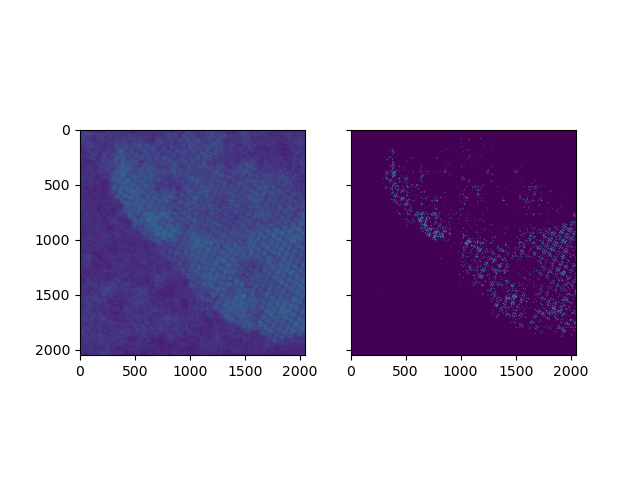

In [89]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True)

ax1.imshow(image)
ax2.imshow(stitched_image)